In [ ]:
# [collapse: code] Colab Setup (Install Dependencies)

# Only run this if we are in Google Colab
if 'google.colab' in str(get_ipython()):
    print("Installing dependencies from pyproject.toml...")
    # This installs the repo itself (and its dependencies)
    !apt-get install gmsh 
    !apt-get install -qq xvfb libgl1-mesa-glx
    !pip install pyvista -qq
    !pip install -q "git+https://github.com/smec-ethz/tatva-docs.git"    
    print("Installation complete!")
else:
    import pyvista as pv


we consider a fiber-reinforced composite in which stiff 1D fibers are embedded in a soft 2D soft material. A central difficulty in such problems is that the fiber geometry typically does not align with the bulk mesh. The fibers may intersect bulk elements at arbitrary positions and orientations. In this example, we use an embedded-element approach formulated entirely at the level of the total potential energy.

In [2]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision

from functools import partial
from typing import NamedTuple

import equinox as eqx
import jax.numpy as jnp
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator, element

In [18]:
# [collapse: code] Mesh Generation

import os

import gmsh
import matplotlib.pyplot as plt
import meshio
import numpy as np


def generate_plate_mesh(
    Lx: float, Ly: float, mesh_size: float, work_dir: str = "."
) -> Mesh:
    """
    Generates a 2D unstructured triangular mesh for a rectangular plate.

    Args:
        Lx (float): Length of the plate in the x-direction.
        Ly (float): Length of the plate in the y-direction.
        mesh_size (float): Target mesh size for the mesh generation.
        work_dir (str): Directory to store temporary mesh files.

    Returns:
        Mesh: The generated plate mesh.
    """
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)

    filename = os.path.join(work_dir, "plate_2d.msh")

    gmsh.initialize()
    gmsh.model.add("plate")

    p1 = gmsh.model.geo.addPoint(0, 0, 0, mesh_size)
    p2 = gmsh.model.geo.addPoint(Lx, 0, 0, mesh_size)
    p3 = gmsh.model.geo.addPoint(Lx, Ly, 0, mesh_size)
    p4 = gmsh.model.geo.addPoint(0, Ly, 0, mesh_size)

    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    surface = gmsh.model.geo.addPlaneSurface([loop])

    # 2. Mesh Generation
    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(2)
    gmsh.write(filename)
    gmsh.finalize()

    # 3. Read back with meshio
    m = meshio.read(filename)
    if os.path.exists(filename):
        os.remove(filename)

    points = m.points[:, :2]  # Drop z-coordinate for 2D
    triangles = m.cells_dict["triangle"]

    return Mesh(points, triangles)


def generate_honeycomb_mesh(
    start_x: float,
    start_y: float,
    n_x: int,
    n_y: int,
    side_length: float,
    segments_per_side: int = 1,
) -> Mesh:
    """
    Generates a 2D honeycomb mesh (hexagonal grid) with specified parameters.
    Each hexagon side can be subdivided into smaller segments.

    Args:
        start_x (float): Starting x-coordinate of the honeycomb grid.
        start_y (float): Starting y-coordinate of the honeycomb grid.
        n_x (int): Number of hexagons along the x-direction.
        n_y (int): Number of hexagons along the y-direction.
        side_length (float): Length of each side of the hexagon.
        segments_per_side (int): Number of subdivisions per hexagon side.

    Returns:
        Mesh: The generated honeycomb mesh.
    """

    dx = np.sqrt(3) * side_length
    dy = 1.5 * side_length
    row_offset = (np.sqrt(3) * side_length) / 2.0

    node_map = {}
    coords_list = []
    lines_list = []
    edge_set = set()

    def get_or_create_node(x, y):
        key = (round(x, 6), round(y, 6))
        if key not in node_map:
            idx = len(coords_list)
            coords_list.append([x, y])
            node_map[key] = idx
            return idx
        return node_map[key]

    angles = np.deg2rad([30, 90, 150, 210, 270, 330])

    for row in range(n_y):
        cols_in_this_row = n_x if (row % 2 == 0) else (n_x - 1)
        current_offset = 0.0 if (row % 2 == 0) else row_offset

        for col in range(cols_in_this_row):
            cx = start_x + (col * dx) + current_offset
            cy = start_y + (row * dy)

            corners = []
            for theta in angles:
                vx = cx + side_length * np.cos(theta)
                vy = cy + side_length * np.sin(theta)
                corners.append((vx, vy))

            for k in range(6):
                # Start and End coordinates of the current side
                start_pt = np.array(corners[k])
                end_pt = np.array(corners[(k + 1) % 6])

                # Get the Node Index for the start of the side
                current_node_idx = get_or_create_node(start_pt[0], start_pt[1])

                # Vector along the side
                side_vector = end_pt - start_pt

                for i in range(1, segments_per_side + 1):
                    # Calculate fraction of distance (e.g., 1/3, 2/3, 3/3)
                    t = i / segments_per_side

                    # Calculate next coordinate
                    next_pt = start_pt + t * side_vector

                    # Get index for this new point
                    next_node_idx = get_or_create_node(next_pt[0], next_pt[1])

                    # Create the small segment
                    edge_key = tuple(sorted((current_node_idx, next_node_idx)))
                    if edge_key not in edge_set:
                        edge_set.add(edge_key)
                        lines_list.append([current_node_idx, next_node_idx])

                    # Move forward
                    current_node_idx = next_node_idx

    return Mesh(np.array(coords_list), np.array(lines_list))

In [19]:
# [output: hide] 

Lx, Ly = 2.0, 2.0
plate_mesh = generate_plate_mesh(Lx=Lx, Ly=Ly, mesh_size=0.04)
n_nodes = plate_mesh.coords.shape[0]
n_dofs_per_node = 2  
n_dofs = n_nodes * n_dofs_per_node

fiber_mesh = generate_honeycomb_mesh(
    start_x=0.6, start_y=0.7, n_x=3, n_y=3, side_length=0.2, segments_per_side=3
)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000440115s, CPU 0.00057s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.103935s, CPU 0.103244s)
Info    : 3013 nodes 6028 elements
Info    : Writing './plate_2d.msh'...
Info    : Done writing './plate_2d.msh'



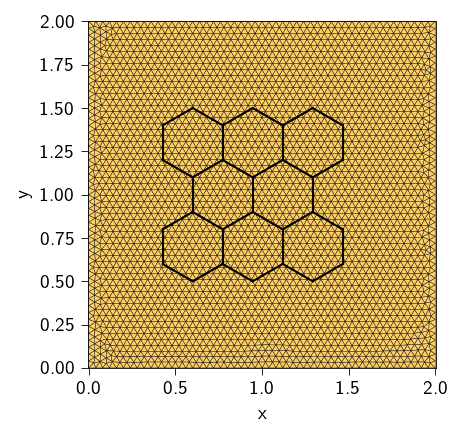

In [ ]:
# [Collapse: code] Visualize Meshes

plt.figure(figsize=(3, 3))
ax = plt.gca()

ax.tripcolor(
    plate_mesh.coords[:, 0],
    plate_mesh.coords[:, 1],
    plate_mesh.elements,
    facecolors=jnp.ones(plate_mesh.elements.shape[0]),
    edgecolors="k",
    cmap="managua",
    lw=0.2,
)

for i, el in enumerate(fiber_mesh.elements):
    p0 = fiber_mesh.coords[el[0]]
    p1 = fiber_mesh.coords[el[1]]
    ax.plot(
        [p0[0], p1[0]],
        [p0[1], p1[1]],
        "k-",
        lw=1,
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis("equal")
ax.margins(0.0, 0.0)
plt.show()

We now find the bulk material elements that contain the nodes of each fiber and then map these nodes tot he quadrature points of that element.

In [ ]:
# [collapse: code] Barycentric Coordinate Computation and Embedding Logic

def compute_barycentric(p, a, b, c):
    """
    Computes local coordinates (xi, eta) of point p in triangle abc.
    Returns (xi, eta) and a boolean 'is_inside'.
    """
    v0 = c - a
    v1 = b - a
    v2 = p - a

    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    invDenom = 1 / (dot00 * dot11 - dot01 * dot01)
    eta = (dot11 * dot02 - dot01 * dot12) * invDenom
    xi = (dot00 * dot12 - dot01 * dot02) * invDenom

    tol = 1e-10
    is_inside = (xi >= -tol) and (eta >= -tol) and (xi + eta <= 1 + tol)

    return xi, eta, is_inside


def embed_fiber_into_plate(host_mesh, fiber_mesh):

    fiber_nodes = fiber_mesh.coords
    n_nodes = fiber_nodes.shape[0]

    n_triangles = len(host_mesh.elements)

    host_elem_indices = np.full(n_nodes, -1, dtype=int)
    local_coords = np.zeros((n_nodes, 2))  # (xi, eta)

    print(f"Embedding {n_nodes} fiber nodes into {n_triangles} triangles...")

    tri_coords = host_mesh.coords[host_mesh.elements]  # (N_tri, 3, 2)
    tri_min = tri_coords.min(axis=1)
    tri_max = tri_coords.max(axis=1)

    for i, pt in enumerate(fiber_nodes):
        candidates = np.where(
            (pt[0] >= tri_min[:, 0])
            & (pt[0] <= tri_max[:, 0])
            & (pt[1] >= tri_min[:, 1])
            & (pt[1] <= tri_max[:, 1])
        )[0]

        found = False
        for tri_idx in candidates:
            a, b, c = tri_coords[tri_idx]

            xi, eta, is_inside = compute_barycentric(pt, a, b, c)

            if is_inside:
                host_elem_indices[i] = tri_idx
                local_coords[i] = [xi, eta]
                found = True
                break

        if not found:
            print(f"Warning: Fiber segment {i} at {pt} is outside the mesh domain!")

    return {
        "host_elem_indices": host_elem_indices,
        "local_coords": local_coords,  # (xi, eta)
    }

In [17]:
embedding_data = embed_fiber_into_plate(plate_mesh, fiber_mesh)

Embedding 98 fiber nodes into 5824 triangles...


We define two operator one for the bulk material which consists of `Tri3` elements and one for fibers which are 1D elements emebeded in 2D space. For this we define a new elemenr `Line2in3D` which takes the displacements defined in 2D or 3D space and then project this displacement along its tangent vector.

In [ ]:
# [Collapse: code] Define Custom Line Element in 3D for Fiber Representation

class Line2In3D(element.Element):
    """
    A 2-node linear element embedded in 3D space.
    Reference domain: [-1, 1]
    """

    quad_points = jnp.array([[0.0]])
    quad_weights = jnp.array([2.0])

    def shape_function(self, xi: Array) -> Array:
        return jnp.array([0.5 * (1.0 - xi[0]), 0.5 * (1.0 + xi[0])])

    def shape_function_derivative(self, xi: Array) -> Array:
        return jnp.array([[-0.5, 0.5]])

    def get_jacobian(self, xi: Array, nodal_coords: Array) -> tuple[Array, Array]:
        """
        nodal_coords: (2, 3) -> Two nodes in 3D space
        """
        dN_dxi = self.shape_function_derivative(xi)

        J_vec = dN_dxi @ nodal_coords  # (1, 2) @ (2, 3) -> (1, 3)

        detJ = jnp.linalg.norm(J_vec)
        return J_vec, detJ

    def gradient(self, xi: Array, nodal_values: Array, nodal_coords: Array) -> Array:
        """
        Returns the 3D Gradient vector.
        """
        J_vec, detJ = self.get_jacobian(xi, nodal_coords)
        dN_dxi = self.shape_function_derivative(xi)
        du_dxi = dN_dxi @ nodal_values

        du_ds = du_dxi / detJ

        tangent = J_vec / detJ
        grad_u_3d = jnp.vdot(du_ds, tangent)

        return grad_u_3d

In [183]:
op_plate = Operator(plate_mesh, element.Tri3())
op_line = Operator(fiber_mesh, Line2In3D())

## Defining the energy for the bulk material

In [184]:
@autovmap(grad_u=2)
def compute_deformation_gradient(grad_u):
    I = jnp.eye(2)
    F = I + grad_u
    return F


@autovmap(F=2, mu=0, lmbda=0)
def strain_energy(F, mu, lmbda):
    C = F.T @ F
    I1 = jnp.trace(C)
    J = jnp.linalg.det(F)
    # return mu / 2 * (I1 - 3) - lmbda * jnp.log(J) + (lmbda / 2) * (jnp.log(J)) ** 2
    return 0.5 * mu * (I1 - 3 - 2 * jnp.log(J)) + (lmbda / 2) * (jnp.log(J)) ** 2


@jax.jit
def total_material_energy(u_flat: Array) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_grad = op_plate.grad(u)
    F = compute_deformation_gradient(u_grad)
    energy_density = strain_energy(F, mat.mu, mat.lmbda)
    return op_plate.integrate(energy_density)


@autovmap(grad_u=0)
def compute_fiber_energy(grad_u):
    return 0.5 * E_fiber * jnp.dot(grad_u, grad_u) * Area_fiber

In [ ]:
class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float 
    lmbda: float  


mat = Material(mu=1, lmbda=10.0)

E = mat.mu * (3 * mat.lmbda + 2 * mat.mu) / (mat.lmbda + mat.mu)
print(f"Effective Young's Modulus of the Plate: E = {E:.2f}")

Effective Young's Modulus of the Plate: E = 2.91


## Defining energy for the fiber network

We now compute the energy of the fibe network which defined as 

$$
\psi_\text{fiber}(\varepsilon_\text{fiber}) = \frac{1}{2}E_\text{fiber}A_\text{fiber} \varepsilon_\text{fiber}^2
$$

In [186]:
E_fiber = 100 * E  # Much stiffer than bulk
Area_fiber = 0.01

In [187]:
p0 = fiber_mesh.coords[fiber_mesh.elements[:, 0]]
p1 = fiber_mesh.coords[fiber_mesh.elements[:, 1]]
vecs = p1 - p0
lengths = np.linalg.norm(vecs, axis=1)
tangents = vecs / lengths[:, None]  # Unit vectors (N_seg, 2)

host_indices = jnp.array(embedding_data["host_elem_indices"])
local_coords = jnp.array(embedding_data["local_coords"])
fiber_L0 = jnp.array(lengths)
fiber_tangents = jnp.array(tangents)

In [188]:
@eqx.filter_jit
def compute_u_fiber(u_flat: Array, host_indices: Array, local_coords: Array) -> Array:
    u = u_flat.reshape(-1, n_dofs_per_node)

    xi = local_coords[:, 0]
    eta = local_coords[:, 1]
    N1 = 1 - xi - eta
    N2 = xi
    N3 = eta

    u1 = u[host_elems[:, 0]]  # (N_seg, 2)
    u2 = u[host_elems[:, 1]]  # (N_seg, 2)
    u3 = u[host_elems[:, 2]]  # (N_seg, 2)

    u_fiber = N1[:, None] * u1 + N2[:, None] * u2 + N3[:, None] * u3  # (N_seg, 2)

    return u_fiber


@autovmap(u_elem=2, local_coords=1)
def compute_u_at_fiber(u_elem: Array, local_coords: Array) -> Array:
    N = element.Tri3().shape_function(local_coords)  # (3,)
    u_quad = N @ u_elem  # (2,)
    return u_quad


@autovmap(host_elem=1, local_coord=2)
def compute_fiber_stretch(host_elem, local_coord, u):
    u_elem = u[host_elem]  # (3, 2)
    u_at_a = compute_u_at_fiber(u_elem, local_coord[0])
    u_at_b = compute_u_at_fiber(u_elem, local_coord[1])

    strain = (u_at_b - u_at_a) / fiber_L0

    return strain


@eqx.filter_jit
def fiber_strain_energy(
    u_flat: Array,
    host_elems: Array,
    local_coords: Array,
) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_elem = u[host_elems]  # (N_seg, 3, 2)
    u_at_nodes = compute_u_at_fiber(u_elem, local_coords)
    u_grad = op_line.grad(u_at_nodes)  # (N_seg, 1, 2)
    energy_density = compute_fiber_energy(u_grad)  # (N_seg,)
    return op_line.integrate(energy_density)


host_elems = plate_mesh.elements[host_indices]
total_fiber_energy = jax.jit(
    partial(
        fiber_strain_energy,
        host_elems=host_elems,
        local_coords=local_coords,
    )
)

## Coupling the energies

$$
\Psi(\boldsymbol{u}) = \underbrace{\int_{\Omega_{\text{bulk}}} \psi_\varepsilon(\nabla \boldsymbol{u}) ~\mathrm{d\Omega}}_{\Psi_\mathrm{bulk}} + \underbrace{\int_{\Gamma_{\text{fiber}}} \psi_{\text{fiber}}(\epsilon_{\text{fiber}})~ \mathrm{dS}}_{\Psi_{\text{fiber}}}
$$

In [189]:
@jax.jit
def total_energy(u_flat: Array) -> float:
    U_plate = total_material_energy(u_flat)
    U_fiber = total_fiber_energy(u_flat)
    return U_plate + U_fiber


@jax.jit
def total_energy_without_fibre(u_flat: Array) -> float:
    U_plate = total_material_energy(u_flat)
    return U_plate

## Applying boundary conditions

We apply uniaxial tension to the bulk material.

In [190]:
y_max = jnp.max(plate_mesh.coords[:, 1])
y_min = jnp.min(plate_mesh.coords[:, 1])
x_min = jnp.min(plate_mesh.coords[:, 0])
height = y_max - y_min


upper_nodes = jnp.where(jnp.isclose(plate_mesh.coords[:, 1], y_max))[0]
lower_nodes = jnp.where(jnp.isclose(plate_mesh.coords[:, 1], y_min))[0]

fixed_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
    ]
)


applied_disp = height * 0.2  # 10% strain

prescribed_values = jnp.zeros(n_dofs).at[2 * upper_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * upper_nodes + 1].set(applied_disp / 2.0)
prescribed_values = prescribed_values.at[2 * lower_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_nodes + 1].set(-applied_disp / 2.0)

free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

## Matrix-free approach

We use a matrix-free approach to automatically consider the additions terms due to the embedding of the fibers in the bulk material.

In [191]:
gradient = jax.jacrev(total_energy)
gradient_wo_fiber = jax.jacrev(total_energy_without_fibre)


@eqx.filter_jit
def compute_tangent(du, u_prev, gradient):
    du_projected = du.at[fixed_dofs].set(0)
    tangent = jax.jvp(gradient, (u_prev,), (du_projected,))[1]
    tangent = tangent.at[fixed_dofs].set(0)
    return tangent

In [ ]:
# [Collapse: code] Conjugate Gradient Solver and Newton-Krylov Loop

@eqx.filter_jit
def conjugate_gradient(A, b, atol=1e-8, max_iter=100):
    iiter = 0

    def body_fun(state):
        b, p, r, rsold, x, iiter = state
        Ap = A(p)
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter = iiter + 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.logical_and(jnp.sqrt(rsold) > atol, iiter < max_iter)

    x = jnp.full_like(b, fill_value=0.0)
    r = b - A(x)
    p = r
    rsold = jnp.vdot(r, p)

    b, p, r, rsold, x, iiter = jax.lax.while_loop(
        cond_fun, body_fun, (b, p, r, rsold, x, iiter)
    )
    return x, iiter


def newton_krylov_solver(
    u,
    fext,
    gradient,
    compute_tangent,
    fixed_dofs,
):
    fint = gradient(u)
    du = jnp.zeros_like(u)
    iiter = 0
    norm_res = 1.0
    tol = 1e-8
    max_iter = 80
    while norm_res > tol and iiter < max_iter:
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)

        A = eqx.Partial(compute_tangent, u_prev=u, gradient=gradient)
        du, cg_iiter = conjugate_gradient(A=A, b=residual, atol=1e-8, max_iter=100)
        u = u.at[:].add(du)

        fint = gradient(u)
        residual = fext - fint
        residual = residual.at[fixed_dofs].set(0)
        norm_res = jnp.linalg.norm(residual)

        print(f"  Residual: {norm_res:.2e}")
        iiter += 1
    return u, norm_res

In [ ]:
# [output: hide]

u_prev = jnp.zeros(n_dofs)
u_prev_wo_fiber = jnp.zeros(n_dofs)

fext = jnp.zeros(n_dofs)

n_steps = 10
applied_displacement = prescribed_values / n_steps
force_on_top = [0.0]
disp_on_top = [0.0]
force_on_top_wo_fiber = [0.0]
disp_on_top_wo_fiber = [0.0]

for i in range(n_steps):
    u_prev = u_prev.at[fixed_dofs].add(applied_displacement[fixed_dofs])
    u_prev_wo_fiber = u_prev_wo_fiber.at[fixed_dofs].add(
        applied_displacement[fixed_dofs]
    )

    u_new, rnorm = newton_krylov_solver(
        u_prev,
        fext,
        gradient,
        compute_tangent,
        fixed_dofs,
    )

    u_new_wo_fiber, rnorm = newton_krylov_solver(
        u_prev_wo_fiber,
        fext,
        gradient_wo_fiber,
        compute_tangent,
        fixed_dofs,
    )

    u_prev = u_new
    u_prev_wo_fiber = u_new_wo_fiber

    fint = gradient(u_prev).reshape(-1, n_dofs_per_node)
    force_on_top.append(jnp.sum(fint[upper_nodes, 1]))
    disp_on_top.append(jnp.mean(u_prev.reshape(-1, n_dofs_per_node)[upper_nodes, 1]))

    fint_wo_fiber = gradient_wo_fiber(u_prev_wo_fiber).reshape(-1, n_dofs_per_node)
    force_on_top_wo_fiber.append(jnp.sum(fint_wo_fiber[upper_nodes, 1]))
    disp_on_top_wo_fiber.append(
        jnp.mean(u_prev_wo_fiber.reshape(-1, n_dofs_per_node)[upper_nodes, 1])
    )

    print(f"Iteration {i}: Residual Norm = {rnorm:.4e}")

u_sol = u_prev.reshape(n_nodes, n_dofs_per_node)
u_sol_wo_fiber = u_prev_wo_fiber.reshape(n_nodes, n_dofs_per_node)

  Residual: 5.60e+00
  Residual: 2.00e+00
  Residual: 5.44e-01
  Residual: 9.69e-02
  Residual: 9.13e-03
  Residual: 1.82e-04
  Residual: 3.75e-05
  Residual: 2.48e-05
  Residual: 1.38e-05
  Residual: 6.50e-06
  Residual: 5.91e-06
  Residual: 2.19e-06
  Residual: 1.93e-06
  Residual: 8.48e-07
  Residual: 6.57e-07
  Residual: 3.22e-07
  Residual: 2.38e-07
  Residual: 1.17e-07
  Residual: 9.15e-08
  Residual: 4.27e-08
  Residual: 3.37e-08
  Residual: 1.68e-08
  Residual: 9.69e-09
  Residual: 5.65e+00
  Residual: 2.01e+00
  Residual: 5.37e-01
  Residual: 8.60e-02
  Residual: 6.63e-03
  Residual: 8.05e-05
  Residual: 1.75e-05
  Residual: 3.47e-06
  Residual: 1.77e-06
  Residual: 3.77e-07
  Residual: 2.04e-07
  Residual: 4.35e-08
  Residual: 2.39e-08
  Residual: 9.59e-09
Iteration 0: Residual Norm = 9.5937e-09
  Residual: 5.22e+00
  Residual: 1.84e+00
  Residual: 4.82e-01
  Residual: 7.75e-02
  Residual: 5.91e-03
  Residual: 1.26e-04
  Residual: 4.13e-05
  Residual: 1.39e-05
  Residual: 1.5

## Visualization

We now visualize the deformation of the bulk material and the embedded fibres.

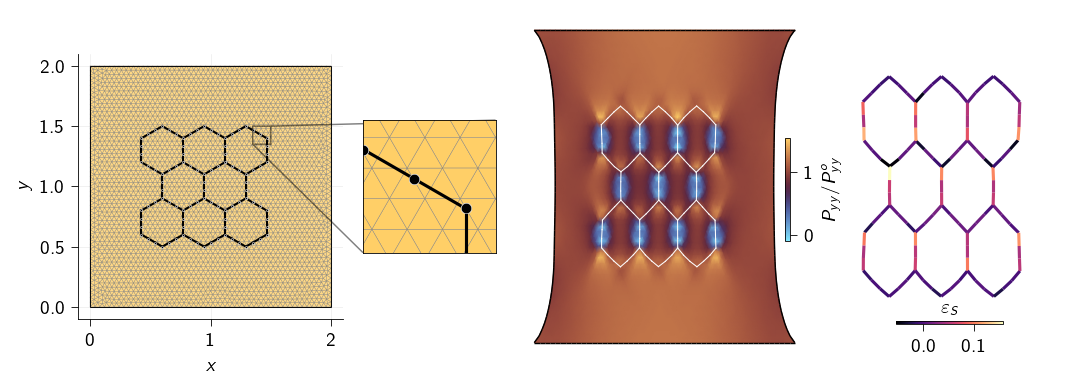

In [ ]:
# [collapse: code] Post-processing and Visualization

import matplotlib.patches as patches
import matplotlib.tri as tri_mat
import pyvista as pv
from matplotlib.collections import LineCollection


def set_size(fraction=1, height_ratio="golden", width="two-column", subplots=(1, 1)):
    if width == "two-column":
        width_pt = 180  # mm
    elif width == "one-column":
        width_pt = 90  # mm
    else:
        width_pt = width

    if height_ratio == "golden":
        ratio_pt = (np.sqrt(5) - 1.0) / 2.0
    else:
        ratio_pt = height_ratio

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1.0 / 25.4
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * ratio_pt * (subplots[0] / subplots[1])
    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


def get_pv_grid(mesh: Mesh) -> pv.UnstructuredGrid:
    """Convert Tatva mesh to PyVista UnstructuredGrid."""
    if mesh.coords.shape[1] == 2:
        pv_points = np.hstack((mesh.coords, np.zeros(shape=(mesh.coords.shape[0], 1))))
    else:
        pv_points = np.array(mesh.coords)
    cells = np.hstack(
        [
            np.full((mesh.elements.shape[0], 1), 3, dtype=np.int64),
            np.array(mesh.elements, dtype=np.int64),
        ]
    )
    grid = pv.UnstructuredGrid(
        cells, np.full(mesh.elements.shape[0], pv.CellType.TRIANGLE), pv_points
    )
    return grid


def find_domain_boundary(elements):
    edges = np.concatenate(
        [elements[:, [0, 1]], elements[:, [1, 2]], elements[:, [2, 0]]], axis=0
    )

    edges_sorted = np.sort(edges, axis=1)

    unique_edges, indices, counts = np.unique(
        edges_sorted, axis=0, return_index=True, return_counts=True
    )

    boundary_edges = edges[indices[counts == 1]]

    return boundary_edges


grad_u = op_plate.grad(u_sol)
F = jnp.eye(2) + grad_u.squeeze()

grad_u_wo_fiber = op_plate.grad(u_sol_wo_fiber)
F_wo_fiber = jnp.eye(2) + grad_u_wo_fiber.squeeze()


def add_bounding_box(ax):
    rect = patches.Rectangle(
        (x_min, y_min),
        Lx,
        Ly,
        linewidth=0.5,
        edgecolor="black",
        facecolor="none",
    )
    ax.add_patch(rect)


def compute_strain_energy_flattened(F_flat):
    F_mat = F_flat.reshape(-1, 2, 2)
    return jnp.sum(strain_energy(F_mat, mat.mu, mat.lmbda))


compute_piola_kirchoff = jax.jacrev(compute_strain_energy_flattened, argnums=0)
P = compute_piola_kirchoff(F.flatten()).reshape(-1, 2, 2)
P_wo_fiber = compute_piola_kirchoff(F_wo_fiber.flatten()).reshape(-1, 2, 2)

grid = get_pv_grid(plate_mesh)
grid["sig_xx"] = P[:, 0, 0] / P_wo_fiber[:, 0, 0]
grid["sig_yy"] = P[:, 1, 1] / P_wo_fiber[:, 1, 1]
grid["sig_xy"] = P[:, 0, 1] / P_wo_fiber[:, 0, 1]
grid["sig_xx_wo_fiber"] = P_wo_fiber[:, 0, 0]
grid["sig_yy_wo_fiber"] = P_wo_fiber[:, 1, 1]
grid["sig_xy_wo_fiber"] = P_wo_fiber[:, 0, 1]

grid: pv.UnstructuredGrid = grid.cell_data_to_point_data()
sample = grid.sample_over_line(
    pointa=(x_min, y_max / 2, 0),
    pointb=(x_min + Lx, y_max / 2, 0),
    resolution=200,
)

u_quad = op_plate.eval(u_sol).squeeze()
u_fiber = u_quad[host_indices]  # (N_seg, 2)
grad_u_fiber = op_line.grad(u_fiber)  # (N_seg, 1, 2)

triang = tri_mat.Triangulation(
    plate_mesh.coords[:, 0] + u_sol[:, 0],
    plate_mesh.coords[:, 1] + u_sol[:, 1],
    plate_mesh.elements,
)


plt.style.use("./latex_sans_serif.mplstyle")
fig = plt.figure(
    figsize=set_size(height_ratio=0.7, subplots=(2, 4)),
    layout="constrained",
)
gs = fig.add_gridspec(
    1,
    4,
    width_ratios=[0.8, 0.4, 0.9, 0.7],
    wspace=0.075,
)
ax = fig.add_subplot(gs[0, 0])
bx = fig.add_subplot(gs[0, 2])
ex = fig.add_subplot(gs[0, 3])

cb = ax.tripcolor(
    *plate_mesh.coords.T,
    plate_mesh.elements,
    facecolors=jnp.ones(plate_mesh.elements.shape[0]),
    edgecolors="gray",
    lw=0.2,
    alpha=0.8,
    cmap="managua",
)

add_bounding_box(ax)

axins = fig.add_subplot(gs[0, 1])
axins.tripcolor(
    *plate_mesh.coords.T,
    plate_mesh.elements,
    facecolors=jnp.ones(plate_mesh.elements.shape[0]),
    edgecolors="gray",
    lw=0.2,
    alpha=1.0,
    cmap="managua",
)
axins.set(xticks=[], yticks=[])
axins.set_xlim(1.35, 1.5)
axins.set_ylim(1.35, 1.5)
axins.set_aspect("equal", adjustable="box")
axins.grid(True)
ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=0.7)


cb = bx.tripcolor(
    triang,
    grid["sig_yy"].flatten(),
    cmap="managua_r",
    shading="gouraud",
)


cax = fig.add_axes((0.73, 0.375, 0.005, 0.275))
cb = plt.colorbar(
    cb,
    cax=cax,
    label=r"$P_{yy}/P_{yy}^{o}$",
    shrink=0.7,
    pad=0.01,
    orientation="vertical",
)
cb.ax.xaxis.set_label_position("top")

edge_elems = find_domain_boundary(plate_mesh.elements)

segments = plate_mesh.coords[edge_elems][:, :, :2]
coll_boundary = LineCollection(
    segments + u_sol[edge_elems][:, :, :2], colors="k", linewidths=0.7
)
bx.add_collection(coll_boundary)

for coords, disp in zip(
    fiber_mesh.coords[fiber_mesh.elements], u_fiber[fiber_mesh.elements]
):
    axins.plot(
        coords[:, 0],
        coords[:, 1],
        color="k",
        linewidth=1.5,
        markersize=5,
        marker="o",
    )
    ax.plot(
        coords[:, 0],
        coords[:, 1],
        color="k",
        marker="o",
        markersize=1,
    )
    bx.plot(
        coords[:, 0] + disp[:, 0],
        coords[:, 1] + disp[:, 1],
        color="white",
        linewidth=0.5,
    )

segments = fiber_mesh.coords[fiber_mesh.elements] + u_fiber[fiber_mesh.elements]
lc = LineCollection(segments, linewidth=1.5, cmap="magma")
lc.set_array(grad_u_fiber.flatten())

lines = ex.add_collection(lc)
cax = fig.add_axes((0.835, 0.15, 0.1, 0.01))
cb = plt.colorbar(
    lines,
    cax=cax,
    label=r"$\varepsilon_S$",
    shrink=0.7,
    pad=0.01,
    orientation="horizontal",
)
cb.ax.xaxis.set_label_position("top")


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ax.set_xlim([x_min - 0.1, x_min + Lx + 0.1])
# ax.set_ylim([y_min - 0.1, y_min + Ly + 0.1])
ex.set_xlim([x_min + 0.35, x_min + Lx - 0.35])
ex.set_ylim([y_min + 0.35, y_min + Ly - 0.35])
ax.set_aspect("equal", adjustable="box")
bx.set_aspect("equal", adjustable="box")
ex.set_aspect("equal", adjustable="box")

ax.grid(True)
ax.set(xlabel=r"$x$", ylabel=r"$y$")
bx.set(xlabel=r"$x$")
ex.set(xlabel=r"$x$")
bx.set_yticklabels([])
bx.set_yticks([])
bx.set_axis_off()
ex.set_yticklabels([])
ex.set_yticks([])
ex.set_axis_off()
ex.margins(0.01, 0.01)
plt.show()